In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
    & +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} (\eta - 1) \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + (\eta -1)(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2} (\eta - 1) \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}(\eta -1)\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [4]:
def simulate_jump(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y = np.mean(θ_list)*290
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [6]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξa = 1/10_000
ξw = 1000
ξp = 1/20
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one(y_grid, numy_bar, args,)

episode: 10000,	 ode error: 2.9836257780052828e-06,	 ft error: 9.19829728727543e-07
episode: 3460,	 ode error: 3.1596681112508137e-06,	 ft error: 9.997680877615878e-09
episode: 3849,	 ode error: 1.0980857351476427e-05,	 ft error: 9.972572351246711e-09
episode: 990,	 ode error: 1.1747612404004076e-05,	 ft error: 9.993295010946035e-09


In [7]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

In [8]:
πᶜt.shape

(100, 144)

(array([0.09106753, 0.10786794, 0.17278886, 0.28061183, 0.38512831,
        0.54520328, 0.40026035, 0.81470183, 1.3327409 , 0.65694886,
        0.97674451, 0.63172409, 0.53331851, 0.70731586, 0.72538728]),
 array([1.0154    , 1.13499133, 1.25458267, 1.374174  , 1.49376533,
        1.61335667, 1.732948  , 1.85253933, 1.97213067, 2.091722  ,
        2.21131333, 2.33090467, 2.450496  , 2.57008733, 2.68967867,
        2.80927   ]),
 <BarContainer object of 15 artists>)

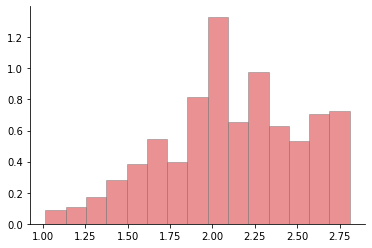

In [15]:
plt.hist(θ_list*1000, weights=πᶜt[-1], density=True, color='tab:red', bins=15, histtype='bar', ec='gray', alpha=.5,)

(0.0, 103.95)

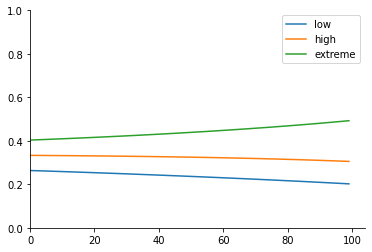

In [21]:
plt.plot(πᵈt[:,0], label="low")
plt.plot(πᵈt[:,1], label="high")
plt.plot(πᵈt[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(left=0)

In [19]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    # ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
    ax3.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

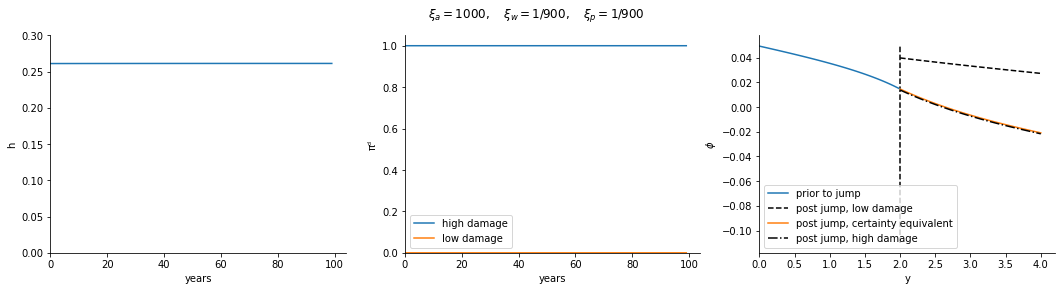

In [20]:
args_plot = (ξa, ξw, ξp, numy_bar)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

In [ ]:
ξₐ = 1000
ξ = 1/400
ξₘ = 10*ξ
dmg_weight = np.array([0.5, 0.5, 0.])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_avg, ems_avg, πᶜ_avg, ι_avg, πᵈ_avg, h_avg, ϕ_avg_list = approach_one(y_grid, numy_bar, args,)

yt_avg, et_avg, πᵈt_avg, πᶜt_avg, ιt_avg, ht_avg = simulate_jump(y_grid[:numy_bar+1], ems_avg, πᶜ_avg, πᵈ_avg, ι_avg, h_avg, θ_list)

In [ ]:
ξₘ = 10*ξ
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 10\ \xi_w $')
ax1.plot(ht_avg[ht_avg>0])
ax1.set_ylim(bottom=0, top=0.15)
ax1.set_xlim(left=0)
ax1.set_xlabel('years')
ax1.set_ylabel('h')
ax2.plot(πᵈt_avg[:,1][πᵈt_avg[:,1]>0], label="high damage")
ax2.plot(πᵈt_avg[:,0][πᵈt_avg[:,0]>0], label="low damage")
# ax2.plot(πᵈt[:,2], label="extreme")
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=0)
ax2.legend()
ax2.set_xlabel('years')
ax2.set_ylabel('πᵈ')
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_avg_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ_avg, label="prior to jump")
ax3.plot(y_grid[numy_bar:], ϕ_avg_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_avg_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
# ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
ax3.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()
# plt.savefig("phi_x10.pdf", facecolor="w", edgecolor='w', bbox_inches="tight")

In [ ]:
ξₐ = 1000
ξ = 1/400
ξₘ = 5*ξ
dmg_weight = np.array([0.5, 0.5, 0.])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_5, ems_5, πᶜ_5, ι_5, πᵈ_5, h_5, ϕ_5_list = approach_one(y_grid, numy_bar, args,)
yt_5, et_5, πᵈt_5, πᶜt_5, ιt_5, ht_5 = simulate_jump(y_grid[:numy_bar+1], ems_5, πᶜ_5, πᵈ_5, ι_5, h_5, θ_list)

In [ ]:
ξₘ = 5*ξ
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p =  5\ \xi_w $')
ax1.plot(ht_5)
ax1.set_ylim(bottom=0, top=0.15)
ax1.set_xlim(left=0)
ax1.set_xlabel('years')
ax1.set_ylabel('h')
ax2.plot(πᵈt_5[:,1][πᵈt_5[:,1]>0], label="high damage")
ax2.plot(πᵈt_5[:,0][πᵈt_5[:,0]>0], label="low damage")
# ax2.plot(πᵈt[:,2], label="extreme")
ax2.set_ylim(bottom=0,top=1)
ax2.set_xlim(left=0)
ax2.legend()
ax2.set_xlabel('years')
ax2.set_ylabel('πᵈ')
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_5_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ_5, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_5_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_5_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
# ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
ax3.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()
# ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
# plt.savefig("phi_x5.pdf", facecolor="w", edgecolor='w', bbox_inches="tight")

In [ ]:
ξₐ = 1000
ξ = 1/400
ξₘ = 1000
dmg_weight = np.array([0.5, 0.5, 0.])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_n, ems_n, πᶜ_n, ι_n, πᵈ_n, h_n, ϕ_n_list = approach_one(y_grid, numy_bar, args,)
yt_n, et_n, πᵈt_n, πᶜt_n, ιt_n, ht_n = simulate_jump(y_grid[:numy_bar+1], ems_n, πᶜ_n, πᵈ_n, ι_n, h_n, θ_list)

In [ ]:
ξₘ = 1000
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p =  1000$')
ax1.plot(ht_n[ht_n>0])
ax1.set_ylim(bottom=0, top=0.15)
ax1.set_xlim(left=0)
ax1.set_xlabel('years')
ax1.set_ylabel('h')
ax2.plot(πᵈt_n[:,1][πᵈt_n[:,1]>0], label="high damage")
ax2.plot(πᵈt_n[:,0][πᵈt_n[:,0]>0], label="low damage")
# ax2.plot(πᵈt[:,2], label="extreme")
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=0)
ax2.legend()
ax2.set_xlabel('years')
ax2.set_ylabel('πᵈ')
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_n_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ_n, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_n_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_n_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
# ax3.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
ax3.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()
# ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
plt.savefig("phi_n.pdf", facecolor="w", edgecolor='w', bbox_inches="tight")

In [ ]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)

In [ ]:
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))

In [ ]:
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et*1000
scc_10 = η*(α - invkap)*np.exp(Kt)/(1-η)/et_avg*1000
scc_5 = η*(α - invkap)*np.exp(Kt)/(1-η)/et_5*1000
scc_n = η*(α - invkap)*np.exp(Kt[et_n>0])/(1-η)/et_n[et_n>0]*1000

In [ ]:
colors = ['royalblue', 'red', 'forestgreen', 'darkorange']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(et_n[et_n > 0], label="$\\xi_p = 1000$", color=colors[0])
ax1.plot(et_avg, label="$\\xi_p = 10\ \\xi_w$", color=colors[1])
ax1.plot(et_5, label="$\\xi_p = 5 \ \\xi_w$", color=colors[2])
ax1.plot(et, label="$\\xi_p =  \\xi_w $", color=colors[3])
ax1.legend()
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=0, top=12)
ax1.set_ylabel('$\\tilde e$')
ax1.set_xlabel('years')
# subplot 2
ax2.plot(scc, label="$\\xi_p = \\xi_w$", color=colors[3])
ax2.plot(scc_5, label="$\\xi_p = 5\ \\xi_w $", color=colors[2])
ax2.plot(scc_10, label='$\\xi_p = 10\ \\xi_w$', color=colors[1])
ax2.plot(scc_n, label="$\\xi_p = 1000$", color=colors[0])
ax2.legend()
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)
ax2.set_ylabel('SCC')
ax2.set_xlabel('years')
# plt.savefig("scc.pdf")

# partition: carbon and temp

In [ ]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θtemp_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_temp, ems_temp, πᶜ_temp, ι_temp, πᵈ_temp, h_temp, ϕ_temp_list = approach_one(y_grid, numy_bar, args, tol=2e-6)

In [ ]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_temp_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_temp)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
yt_temp, et_temp, πᵈt_temp, πᶜt_temp, ιt_temp, ht_temp = simulate_jump(y_grid[:numy_bar+1], ems_temp, πᶜ_temp, πᵈ_temp, ι_temp, h_temp, θtemp_list)

In [ ]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θcarb_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_carb, ems_carb, πᶜ_carb, ι_carb, πᵈ_carb, h_carb, ϕ_carb_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

In [ ]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_carb_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_carb)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
yt_carb, et_carb, πᵈt_carb, πᶜt_carb, ιt_carb, ht_carb = simulate_jump(y_grid[:numy_bar+1], ems_carb, πᶜ_carb, πᵈ_carb, ι_carb, h_carb,  θcarb_list)

In [ ]:
plt.plot(ht[ht>0], label="neutral")
plt.plot(ht_carb[ht_carb>0], label = "carbon")
plt.plot(ht_temp[ht_temp>0], label = "temperature")
plt.plot(ht_avg[ht_avg>0], label = "climate")
plt.legend()
plt.ylabel('h')
plt.xlabel('years')
# plt.ylim(0,0.0035)

In [ ]:
plt.plot(yt[yt>0],label="no ambiguity over climate models")
# plt.plot(yt_carb[yt_carb>0],label="ambiguity over carbon models")
# plt.plot(yt_temp[yt_temp>0],label="ambiguity over temperature models")
plt.plot(yt_avg[yt_avg>0],label="ambiguity over 144 climate models")
plt.legend()

In [ ]:
plt.plot(et[et>0], label="ambiguity neutral")
# plt.plot(et_carb[et_carb>0], label="ambiguity over carbon models")
# plt.plot(et_temp[et_temp>0], label="ambiguity over temperature models")
plt.plot(et_avg[et_avg>0], label="ambiguity over climate models")
plt.legend(frameon=False)
plt.ylabel("$\\tilde e$")
plt.xlabel('Years')
plt.ylim(bottom=0)
plt.xlim(0,100)
# plt.savefig("../figures/ems_partition_damage.png", facecolor='w', edgecolor='w',bbox_inches="tight")

# SCC uncertainty decomposition
First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + (\eta-1)(\gamma_2 + \gamma_3\mathcal{I}\{y>\bar y\}) \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\delta\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  &- \delta \phi(y) + \delta\eta \log\tilde e^* + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}(\eta -1)\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e^* \theta_i
\end{aligned}
$$

In [ ]:
# solve for decompose
def solve_decompose(y_grid, numy_bar, ems_star, ϕ_list, args, ϵ=0.3, tol=1e-8, max_iter=10_000):
    """compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy = args
    # solve for HJB with jump function
    ems_star = ems_star[:numy_bar+1]
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = np.ones_like(y_grid_cap)*(-δ)
    B = θ*ems_star
    C = .5*σy**2*ems_star**2
    D = δ*η*np.log(ems_star) + (η-1)*dΛ*ems_star*θ + .5*(η-1)*ddΛ*σy**2*ems_star**2
    bc = np.average(ϕ_list, axis=0, weights=dmg_weight)
    ϕ = bc[:numy_bar+1]
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (True, bc[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

    v0_dy = compute_derivatives(ϕ, 1, dy, central_diff=False)
    v0_dyy = compute_derivatives(ϕ, 2, dy)

    error = np.max(abs(A*ϕ + B*v0_dy + C*v0_dyy + D))
    
    ME = -(v0_dy+(η-1)*dΛ)*θ - (v0_dyy+(η-1)*ddΛ)*σy**2*ems_star
    ratio = ME/(δ*η/ems_star)

    print("Solved. PDE error: %s" % (error))  
    return ME, ratio

In [ ]:
ς = 0.1
ξₐ = 1000
ξ = 1000
ξₘ = 1/80
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_5, ems_5, πᶜ_5, ι_5, πᵈ_5, h_5, ϕ_5_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME5, ratio = solve_decompose(y_grid, numy_bar, ems_5, ϕ_5_list, args)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

In [ ]:
plt.plot(-np.log(ME5/(δ*η/ems_5))*100)
plt.ylim(bottom=0)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

In [ ]:
plt.plot(ratio)
plt.ylim(0,1)

In [ ]:
plt.hist(ht)
plt.ylim(0, 0.3)

In [ ]:
def plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, ME):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend()
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=15, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=15, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: ' + str((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend()
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.legend()
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')

In [ ]:
ξₐ = 1000
ξ = 1000
ξₘ = 1000
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
_, et_base, _, _, _, _ = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

In [ ]:
plt.plot(et_base[et_base>0])

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = 60*ξ
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_60.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = 30*ξ
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_30.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = ξ
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_1.pdf')
plt.show()

In [ ]:
ξₐ = 1/15_000
ξ = 1/600
ξₘ = 1000
dmg_weight = np.array([0.5, 0.5, 0])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = approach_one(y_grid, numy_bar, args, max_iter=5_000)
ME, ratio = solve_decompose(y_grid, numy_bar, ems, ϕ_list, args)
yt, et, πᵈt, πᶜt, ιt, ht, me = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, ME, θ_list)

In [ ]:
plot_together(et, ratio, θ_list, ht, πᶜt, πᵈt, me)
# plt.savefig('15_600_1000.pdf')
plt.show()